___
# Trabalho Prático – Planejamento e Navegação
**Estudante: Nathan Augusto Zacarias Xavier**

# Introdução

O objetivo deste trabalho prático é ter um contato com as ferramentas de simulação e programação. O software de simulação é o CoppeliaSim, enquanto a linguagem de programação indicada foi a Python, desenvolvido via Jupyter Notebook.

## Mapas de Simulação

Buscando equiparar e comparar as diferentes técnicas de planejamento e controle, foram desenvolvidos três mapas distintos e com propostas distintas, a seguir apresentados.

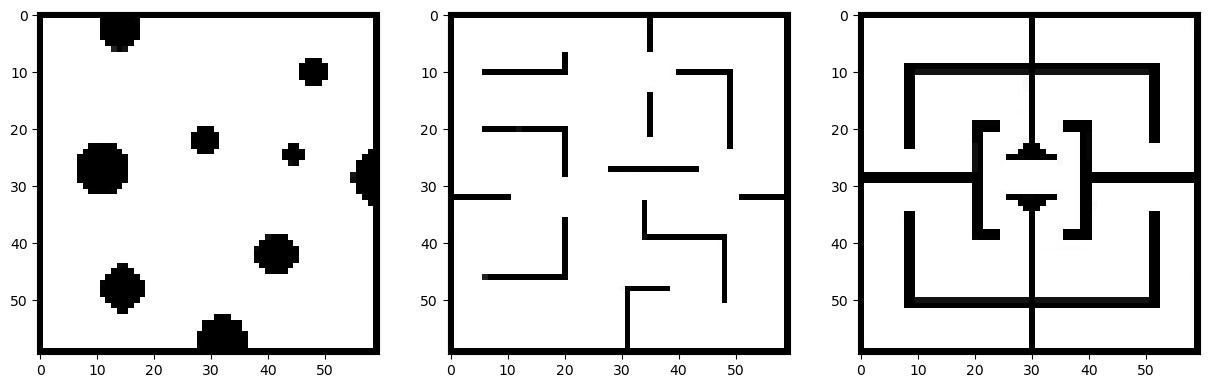

In [1]:
# Bibliotecas de Interesse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns
import imageio
import math
import networkx as nx
import time
from scipy.interpolate import interp1d

# Importação do Mapa
fig = plt.figure(figsize=(15,15), dpi=100)
ax0 = fig.add_subplot(131, aspect='equal')
img0 = mpimg.imread('Mapa0.png')
ax0.imshow(img0, cmap='Greys', origin='upper');

ax1 = fig.add_subplot(132, aspect='equal')
img1 = mpimg.imread('Mapa1.png')
ax1.imshow(img1, cmap='Greys', origin='upper');

ax2 = fig.add_subplot(133, aspect='equal')
img2 = mpimg.imread('Mapa2.png')
ax2.imshow(img2, cmap='Greys', origin='upper');

threshold = 0.5
img0 = 1-img0
img1 = 1-img1
img2 = 1-img2
img0[img0 > threshold] = 1
img1[img1 > threshold] = 1
img2[img2 > threshold] = 1
img0[img0 <= threshold] = 0
img1[img1 <= threshold] = 0
img2[img2 <= threshold] = 0

O primeiro mapa possui áreas amplas e com poucos obstáculos disponíveis. Estende-se que, o planejamento e a navegação de movimento não seria tão problemático para os robôs, sendo possível alcançar a posição final com demasiada facilidade.

O segundo mapa foi proposto criando áreas mais restritas, possivelmente havendo obstáculos por todo o percurso e com um caminho único para alcançar o objetivo.

Por fim, o terceiro mapa é similar a um labirinto, também com caminhos únicos e até com um espaço menor de mobilidade. Importante observar que, diferente do segundo mapa, a navegação pode obrigar que o robô vá em uma direção oposta à posição final, fazendo com que o erro de posição seja cada vez sempre maior.

A seguir, são apresentadas algumas análises prévias para a navegação nos ambientes:

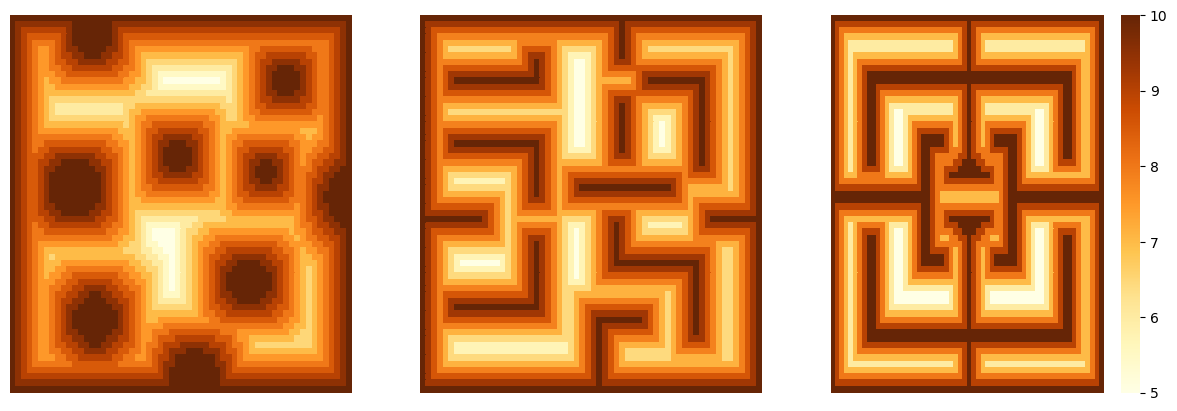

In [2]:
# Dimensões do mapa informado em metros (X, Y)
mapCoppelia = 20
map_dims = mapCoppelia*np.array([30, 30])
sy, sx = img0.shape[:2] / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = mapCoppelia/2

rMC = (map_dims/cell_size)/mapCoppelia # Ajuste Mapa->Coppelia

rows, cols = (map_dims / cell_size).astype(int)

grid0 = np.zeros((rows, cols))
grid1 = np.zeros((rows, cols))
grid2 = np.zeros((rows, cols))
heatMap0 = np.zeros((rows, cols))
heatMap1 = np.zeros((rows, cols))
heatMap2 = np.zeros((rows, cols))

# Preenchendo o Grid
for r in range(rows):
    for c in range(cols):
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
        grid0[r, c] = np.sum(img0[yi:yf,xi:xf])
        grid1[r, c] = np.sum(img1[yi:yf,xi:xf])
        grid2[r, c] = np.sum(img2[yi:yf,xi:xf])
        if grid0[r, c]>threshold: grid0[r,c] = heatMap0[r,c] = 10
        else: grid0[r,c] = heatMap0[r,c] = 0
        if grid1[r, c]>threshold: grid1[r,c] = heatMap1[r,c] = 10
        else: grid1[r,c] = heatMap1[r,c] = 0
        if grid2[r, c]>threshold: grid2[r,c] = heatMap2[r,c] = 10
        else: grid2[r,c] = heatMap2[r,c] = 0
        

# Definição dos pesos de cada grid
for idGrid in range(9, 0, -1):
    for r in range(rows):
        for c in range(cols):
            # Mapa 0
            if heatMap0[r, c] == 0:
                nObs = 0
                try:
                    for i in range(r-1, r+2):
                        for j in range(c-1, c+2):
                            if heatMap0[i,j]>idGrid:
                                nObs = idGrid
                except:
                    'Do Nothing'
                heatMap0[r,c] = nObs
            # Mapa 1
            if heatMap1[r, c] == 0:
                nObs = 0
                try:
                    for i in range(r-1, r+2):
                        for j in range(c-1, c+2):
                            if heatMap1[i,j]>idGrid:
                                nObs = idGrid
                except:
                    'Do Nothing'
                heatMap1[r,c] = nObs
            # Mapa 2
            if heatMap2[r, c] == 0:
                nObs = 0
                try:
                    for i in range(r-1, r+2):
                        for j in range(c-1, c+2):
                            if heatMap2[i,j]>idGrid:
                                nObs = idGrid
                except:
                    'Do Nothing'
                heatMap2[r,c] = nObs

fig = plt.figure(figsize=(15,5), dpi=100);
ax0 = fig.add_subplot(131);
ax0 = sns.heatmap(heatMap0, cmap="YlOrBr", xticklabels=False, yticklabels=False, cbar=False);
ax1 = fig.add_subplot(132);
ax1 = sns.heatmap(heatMap1, cmap="YlOrBr", xticklabels=False, yticklabels=False, cbar=False);
ax2 = fig.add_subplot(133);
ax2 = sns.heatmap(heatMap2, cmap="YlOrBr", xticklabels=False, yticklabels=False);

A partir dos Heatmaps dos mapas discretizados, observa-se que diferentes posições somente serão interligadas caso o robô seja capaz de caminhar por regiões onde os obstáculos introduzem grande influência no ambiente.

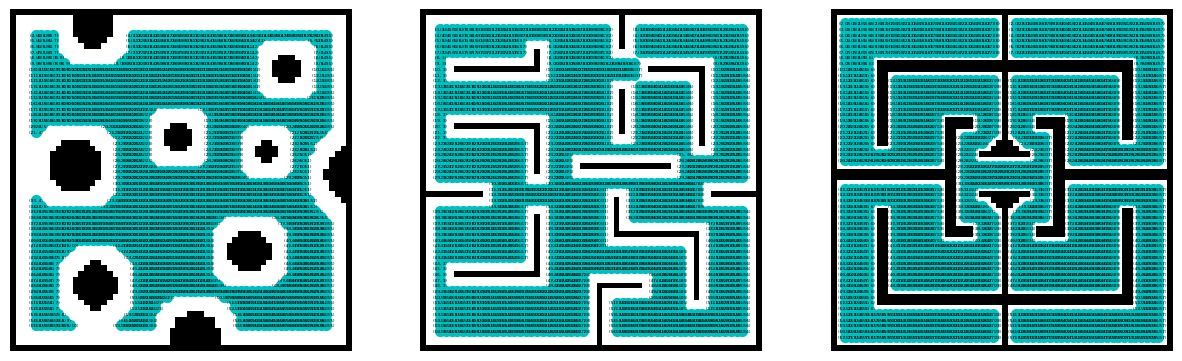

In [3]:
# Criando o Grafo para o nosso Grid
G0 = nx.grid_2d_graph(rows, cols);
G1 = nx.grid_2d_graph(rows, cols);
G2 = nx.grid_2d_graph(rows, cols);

# Validação dos grids (C-Space)
for r in range(rows):
    for c in range(cols):
        # Mapa 0
        if heatMap0[r][c] > 6:
            G0.remove_node((r,c))
        # Mapa 1
        if heatMap1[r][c] > 7:
            G1.remove_node((r,c))
        # Mapa 2
        if heatMap2[r][c] > 8:
            G2.remove_node((r,c))

fig = plt.figure(figsize=(15,15), dpi=100)
ax0 = fig.add_subplot(131, aspect='equal')
ax1 = fig.add_subplot(132, aspect='equal')
ax2 = fig.add_subplot(133, aspect='equal')

# Grid
obj0 = ax0.imshow(grid0, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))
obj1 = ax1.imshow(grid1, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))
obj2 = ax2.imshow(grid2, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

ax0.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax1.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax2.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax0.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax1.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax2.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax0.set_yticks(np.arange(0, map_dims[0]+1, cell_size))
ax1.set_yticks(np.arange(0, map_dims[0]+1, cell_size))
ax2.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Os vértices serão plotados no centro da célula
mapaAllPos0 = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G0.nodes()}
nx.draw(G0, mapaAllPos0, font_size=3, with_labels=True, node_size=50, node_color="c", ax=ax0)

mapaAllPos1 = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G1.nodes()}
nx.draw(G1, mapaAllPos1, font_size=3, with_labels=True, node_size=50, node_color="c", ax=ax1)

mapaAllPos2 = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G2.nodes()}
nx.draw(G2, mapaAllPos2, font_size=3, with_labels=True, node_size=50, node_color="c", ax=ax2)

Por fim, os mapas acima apresentado com posições válidas de movimento, demonstra quais os caminhos podem ser 
interligados, e como a distância ao obstáculo é crucial ao movimento. Como esperado, o 1º mapa, por apresentar obstáculos mais espaçados, pode-se movimentar e alcançar diferentes localizações mantendo uma distância maior dos obstáculos, comparado ao 3º mapa, onde os caminhos somente existem caso o robô se mova muito próximo dos obstáculos.

Assim, com os mapas construídos e analisados, pode-se realizar as diferentes simulações dos robôs e das técnicas. Nota-se que, para que as simulações funcionem, é necessário que os mapas estejam previamente processados.

___
# Roadmap - Robô Holonômico

A primeira simulação é desenvolvida utilizando um Robô Holonômico e a técnica de Roadmap. A partir das análises dos mapas já realizados, optou-se pela Decomposição em Grid, conforme já indicado anteriormente.

A escolha deste modelo leva em consideração as cenas criadas, uma vez que as formas dos obstáculos não são lineares, havendo imperfeições no mapa discretizado e na simulação.

A seguir são apresentadas as simulações do Robô Holonômico em cada um dos mapas descritos.

### Mapa 0

In [4]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

Connected to remote API server
Tempo de Planejamento =  0.5251736640930176
Program ended


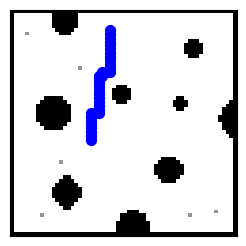

In [11]:
planTime = time.time()

# Importação das informações do mapa
mapaAllPos = mapaAllPos0
G = G0
grid = grid0

# Posição Final Aleatória Válida
posValid = [0,0,0]
posValid[:2] = random.choice(list(mapaAllPos)) # Posição Final Aleatória
posValid[2] = 180*random.random() # Orientação Final Aleatória

# Validação da Posição Final
mapaGoal = np.array([posValid[0], posValid[1], np.deg2rad(posValid[2])])
fGoal = 0
try:
    G[mapaGoal[0], mapaGoal[1]]
    fGoal = 1;
except:
    print ('Posição Final Inválida')

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1 and fGoal):
    print ('Connected to remote API server')
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Configuração Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
    
    # Dados do Coppelia
    robotname = 'robotino'
    returnCode, roboHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
    
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    # Frame que representa o Goal
    returnCode, checkpointFrame = sim.simxGetObjectHandle(clientID, 'CheckPoints', sim.simx_opmode_oneshot_wait)
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    
    # Criação do Percurso
    mapaRobo = [abs(round((roboPos[1]-mapCoppelia/2)*rMC[0])), round((roboPos[0]+mapCoppelia/2)*rMC[1]), roboOri[2]]
    start_node =  (mapaRobo[0], mapaRobo[1])
    path = nx.shortest_path(G, source=start_node, target=tuple(mapaGoal[0:2]))
    
    #Definição do Goal
    mapaGoal[:2] = [-((mapaGoal[0]/rMC[0])-mapCoppelia/2), (mapaGoal[1]/rMC[1])-mapCoppelia/2]
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [mapaGoal[1], mapaGoal[0], .5], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, mapaGoal[2]], sim.simx_opmode_oneshot_wait)
    
    print("Tempo de Planejamento = ", time.time()-planTime)
    
    # Simulação de movimento baseado no caminho definido
    for posPath in path:
        
        # Transformação Ref.Mapa -> Ref.Coppelia
        qgoal = np.array([posPath[0], posPath[1], mapaGoal[2]])
        qgoal[:2] = [(qgoal[1]/rMC[0])-mapCoppelia/2, -((qgoal[0]/rMC[1])-mapCoppelia/2)]
        
        returnCode = sim.simxSetObjectPosition(clientID, checkpointFrame, -1, [qgoal[0], qgoal[1], .5], sim.simx_opmode_oneshot_wait)
        returnCode = sim.simxSetObjectOrientation(clientID, checkpointFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)
        
        Ctrl = np.array([[2, 0, 0], [0, 2, 0], [0, 0, .5]])
        
        rho = np.inf
        while True:
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)        
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
            
            # Ajuste Coppelia -> Mapa
            mapaRobo = np.array([roboPos[0], roboPos[1], roboOri[2]])
            
            error = qgoal -mapaRobo
            
            # Margem aceitável de distância durante Movimento
            if ((np.linalg.norm(error[:2]) < mapCoppelia/70)):
                # Posição Final
                if(posPath == path[-1]):
                    # Correção de Giro, apenas
                    Ctrl = np.array([[.1, 0, 0], [0, .1, 0], [0, 0, 1]])
                    if(error[2]<0.1): break
                else: break
                    
            # Controller
            qdot = Ctrl @ error
            
            # Cinemática Inversa w1, w2, w3
            Minv = np.linalg.inv(Rz(roboOri[2]) @ Mdir)
            u = Minv @ qdot
            
            # Enviando velocidades
            sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
    
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho proposto
    grid[start_node] = 5
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))
    nx.draw_networkx_nodes(G, mapaAllPos, nodelist=path, node_size=50, node_color='b')

print('Program ended')

Na simulação, observa-se que o robô faz somente movimentos ortogonais aos eixos x e y, o que seria o melhor movimento possível no mapa disponível. A figura produzida acima, demonstra também as posições iniciais de movimentos anteriores e o caminho final percorrido, este sendo calculado antes do movimento ser iniciado.

Observa-se que as posições finais são aleatórias, definidas durante a programação. Além disso, o tempo de Planejamento de movimento, considerando o mapa já discretizado, é sempre muito pequeno.

A imagem a seguir mostra, na simulação, todo o caminho percorrido pelo robô.

![title](Sim1_Map0.png)

### Mapa 1

Connected to remote API server
Tempo de Planejamento =  0.48944973945617676
Program ended


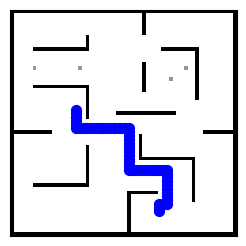

In [16]:
planTime = time.time()

# Importação das informações do mapa
mapaAllPos = mapaAllPos1
G = G1
grid = grid1

# Posição Final Aleatória Válida
posValid = [0,0,0]
posValid[:2] = random.choice(list(mapaAllPos)) # Posição Final Aleatória
posValid[2] = 180*random.random() # Orientação Final Aleatória

# Validação da Posição Final
mapaGoal = np.array([posValid[0], posValid[1], np.deg2rad(posValid[2])])
fGoal = 0
try:
    G[mapaGoal[0], mapaGoal[1]]
    fGoal = 1;
except:
    print ('Posição Final Inválida')

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1 and fGoal):
    print ('Connected to remote API server')
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Configuração Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
    
    # Dados do Coppelia
    robotname = 'robotino'
    returnCode, roboHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
    
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    # Frame que representa o Goal
    returnCode, checkpointFrame = sim.simxGetObjectHandle(clientID, 'CheckPoints', sim.simx_opmode_oneshot_wait)
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    
    # Criação do Percurso
    mapaRobo = [abs(round((roboPos[1]-mapCoppelia/2)*rMC[0])), round((roboPos[0]+mapCoppelia/2)*rMC[1]), roboOri[2]]
    start_node =  (mapaRobo[0], mapaRobo[1])
    path = nx.shortest_path(G, source=start_node, target=tuple(mapaGoal[0:2]))
    
    #Definição do Goal
    mapaGoal[:2] = [-((mapaGoal[0]/rMC[0])-mapCoppelia/2), (mapaGoal[1]/rMC[1])-mapCoppelia/2]
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [mapaGoal[1], mapaGoal[0], .5], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, mapaGoal[2]], sim.simx_opmode_oneshot_wait)
    
    print("Tempo de Planejamento = ", time.time()-planTime)
    
    # Simulação de movimento baseado no caminho definido
    for posPath in path:
        
        # Transformação Ref.Mapa -> Ref.Coppelia
        qgoal = np.array([posPath[0], posPath[1], mapaGoal[2]])
        qgoal[:2] = [(qgoal[1]/rMC[0])-mapCoppelia/2, -((qgoal[0]/rMC[1])-mapCoppelia/2)]
        
        returnCode = sim.simxSetObjectPosition(clientID, checkpointFrame, -1, [qgoal[0], qgoal[1], .5], sim.simx_opmode_oneshot_wait)
        returnCode = sim.simxSetObjectOrientation(clientID, checkpointFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)
        
        Ctrl = np.array([[2, 0, 0], [0, 2, 0], [0, 0, .5]])
        
        rho = np.inf
        while True:
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)        
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
            
            # Ajuste Coppelia -> Mapa
            mapaRobo = np.array([roboPos[0], roboPos[1], roboOri[2]])
            
            error = qgoal -mapaRobo
            
            # Margem aceitável de distância durante Movimento
            if ((np.linalg.norm(error[:2]) < mapCoppelia/70)):
                # Posição Final
                if(posPath == path[-1]):
                    # Correção de Giro, apenas
                    Ctrl = np.array([[.1, 0, 0], [0, .1, 0], [0, 0, 1]])
                    if(error[2]<0.1): break
                else: break
                    
            # Controller
            qdot = Ctrl @ error
            
            # Cinemática Inversa w1, w2, w3
            Minv = np.linalg.inv(Rz(roboOri[2]) @ Mdir)
            u = Minv @ qdot
            
            # Enviando velocidades
            sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
    
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho proposto
    grid[start_node] = 5
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))
    nx.draw_networkx_nodes(G, mapaAllPos, nodelist=path, node_size=50, node_color='b')
    
print('Program ended')

De forma similar ao mapa anterior, o movimento do robô é realizado com sucesso, fazendo com que este alcance todas as posições finais desejadas e válidas, considerando as distâncias aos objetos desejadas.

O resultado final de todos os movimentos são apresentados na imagem a seguir.

![title](Sim1_Map1.png)

### Mapa 2

Connected to remote API server
Tempo de Planejamento =  0.4909200668334961
Program ended


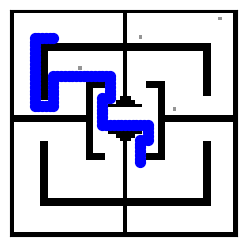

In [22]:
planTime = time.time()

# Importação das informações do mapa
mapaAllPos = mapaAllPos2
G = G2
grid = grid2

# Posição Final Aleatória Válida
posValid = [0,0,0]
posValid[:2] = random.choice(list(mapaAllPos)) # Posição Final Aleatória
posValid[2] = 180*random.random() # Orientação Final Aleatória

# Validação da Posição Final
mapaGoal = np.array([posValid[0], posValid[1], np.deg2rad(posValid[2])])
fGoal = 0
try:
    G[mapaGoal[0], mapaGoal[1]]
    fGoal = 1;
except:
    print ('Posição Final Inválida')

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1 and fGoal):
    print ('Connected to remote API server')
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Configuração Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
    
    # Dados do Coppelia
    robotname = 'robotino'
    returnCode, roboHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
    
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    # Frame que representa o Goal
    returnCode, checkpointFrame = sim.simxGetObjectHandle(clientID, 'CheckPoints', sim.simx_opmode_oneshot_wait)
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    
    # Criação do Percurso
    mapaRobo = [abs(round((roboPos[1]-mapCoppelia/2)*rMC[0])), round((roboPos[0]+mapCoppelia/2)*rMC[1]), roboOri[2]]
    start_node =  (mapaRobo[0], mapaRobo[1])
    path = nx.shortest_path(G, source=start_node, target=tuple(mapaGoal[0:2]))
    
    #Definição do Goal
    mapaGoal[:2] = [-((mapaGoal[0]/rMC[0])-mapCoppelia/2), (mapaGoal[1]/rMC[1])-mapCoppelia/2]
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [mapaGoal[1], mapaGoal[0], .5], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, mapaGoal[2]], sim.simx_opmode_oneshot_wait)
    
    print("Tempo de Planejamento = ", time.time()-planTime)
    
    # Simulação de movimento baseado no caminho definido
    for posPath in path:
        
        # Transformação Ref.Mapa -> Ref.Coppelia
        qgoal = np.array([posPath[0], posPath[1], mapaGoal[2]])
        qgoal[:2] = [(qgoal[1]/rMC[0])-mapCoppelia/2, -((qgoal[0]/rMC[1])-mapCoppelia/2)]
        
        returnCode = sim.simxSetObjectPosition(clientID, checkpointFrame, -1, [qgoal[0], qgoal[1], .5], sim.simx_opmode_oneshot_wait)
        returnCode = sim.simxSetObjectOrientation(clientID, checkpointFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)
        
        Ctrl = np.array([[2, 0, 0], [0, 2, 0], [0, 0, .5]])
        
        rho = np.inf
        while True:
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)        
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
            
            # Ajuste Coppelia -> Mapa
            mapaRobo = np.array([roboPos[0], roboPos[1], roboOri[2]])
            
            error = qgoal -mapaRobo
            
            # Margem aceitável de distância durante Movimento
            if ((np.linalg.norm(error[:2]) < mapCoppelia/70)):
                # Posição Final
                if(posPath == path[-1]):
                    # Correção de Giro, apenas
                    Ctrl = np.array([[.1, 0, 0], [0, .1, 0], [0, 0, 1]])
                    if(error[2]<0.1): break
                else: break
                    
            # Controller
            qdot = Ctrl @ error
            
            # Cinemática Inversa w1, w2, w3
            Minv = np.linalg.inv(Rz(roboOri[2]) @ Mdir)
            u = Minv @ qdot
            
            # Enviando velocidades
            sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
    
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho proposto
    grid[start_node] = 5
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))
    nx.draw_networkx_nodes(G, mapaAllPos, nodelist=path, node_size=50, node_color='b')
    
print('Program ended')

Na simulação, observa-se que o robô é capaz de alcançar os objetivos finais, mas, como o tamanho o espaço de movimento é pequeno, e o robô precisa permanecer dentro do grid, muitas vezes este acaba esbarrando nos obstáculos.

O contato com os obstáculos se dá também pelo uso da biblioteca NetworkX, que faz a especificação do menor caminho possível entre a posição inicial e a final. Caso fosse implementada uma técnica que desconsidera-se esse movimento ótimo, é possível que tal contato não existisse mais.

A seguir, são apresentados os resultados do movimento do robô na cena.

![title](Sim1_Map2.png)

___
# Campos Potenciais - Robô Diferencial

A segunda simulação necessita do uso do Robô Pioneer, que é Não-Holonômico, e utilizando a técnica de Campos Potenciais.
é desenvolvida utilizando um Robô Holonômico e a técnica de Roadmap. A partir das análises dos mapas já realizados, optou-se pela Decomposição em Grid, conforme já indicado anteriormente.

A escolha deste modelo leva em consideração as cenas criadas, uma vez que as formas dos obstáculos não são lineares, havendo imperfeições no mapa discretizado e na simulação.

A seguir são apresentadas as simulações do Robô Holonômico em cada um dos mapas descritos.

### Mapa 0

In [4]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])
# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle+np.pi, 2*np.pi) - np.pi

Connected to remote API server
Tempo de Processamento =  20.32454538345337


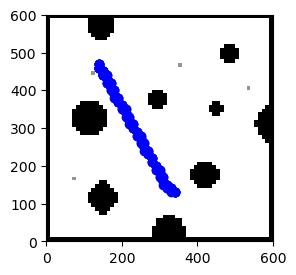

In [9]:
procTime = time.time()

# Importação das informações do mapa
mapaAllPos = mapaAllPos0
G = G0
grid = grid0

# Posição Final Aleatória Válida
posValid = [0,0,0]
posValid[:2] = random.choice(list(mapaAllPos)) # Posição Final Aleatória
posValid[2] = 180*random.random() # Orientação Final Aleatória

# Validação da Posição Final
mapaGoal = np.array([posValid[0], posValid[1], np.deg2rad(posValid[2])])
fGoal = 0
try:
    G[mapaGoal[0], mapaGoal[1]]
    fGoal = 1;
except:
    print ('Posição Final Inválida')

# Goal configuration (x, y, theta)
qgoal = np.array([(mapaGoal[1]/rMC[0])-mapCoppelia/2, -((mapaGoal[0]/rMC[1])-mapCoppelia/2), mapaGoal[2]])
mapaRobox = []
mapaRoboy = []
    
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1 and fGoal):
    print ('Connected to remote API server')
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)

    # Sensores Ultrassônicos
    conjSensores=[]
    angSensores = [np.deg2rad(90), np.deg2rad(50), np.deg2rad(30), np.deg2rad(10),
                   np.deg2rad(-10), np.deg2rad(-30), np.deg2rad(-50), np.deg2rad(-90),
                   np.deg2rad(-90), np.deg2rad(-140), np.deg2rad(-160), np.deg2rad(-170),
                   np.deg2rad(170), np.deg2rad(160), np.deg2rad(140), np.deg2rad(90)]
    for i in range(1,17):
        returnCode, sensorHandle = sim.simxGetObjectHandle(clientID, "Pioneer_p3dx_ultrasonicSensor" +"{}".format(i), sim.simx_opmode_blocking)
        conjSensores.append(sensorHandle)
    
    # Frame que representa o Goal
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [qgoal[0], qgoal[1], 0.5], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)
    
    # Específico do robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    maxSensor = 0.5
    minSensor = 0.2
    
    # Controlador
    katt = .5
    krep = 5
    kr = .5
    ka = 2
    
    startTime = int(time.strftime("%M"))
    fTempo = 0
    rho = np.inf
    while rho > .5 and fTempo == 0:
        returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot)
        returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot)
        
        mapaRobox.append([round((roboPos[0]+mapCoppelia/2)*rMC[1])])
        mapaRoboy.append([abs(round((roboPos[1]-mapCoppelia/2)*rMC[0]))])
        roboConfig = np.array([roboPos[0], roboPos[1], roboOri[2]])
        
        # Relação Robô -> Goal
        dx, dy = qgoal[:2] - roboConfig[:2]
        rho = np.sqrt(dx**2 + dy**2)
        alpha = normalizeAngle(-roboConfig[2] + np.arctan2(dy,dx))
        
        # Alvo na parte de trás
        if abs(alpha) > np.pi/2:
            kv = -kr
            alphaGoal = normalizeAngle(alpha-np.pi)
        else:
            kv = kr
            alphaGoal = alpha
        
        # Campos Potenciais Repulsão
        Frep = np.zeros(2)
        nSensor = 0;
        for sensorHandle in conjSensores[0:16]:
            sensInfo = sim.simxReadProximitySensor(clientID, sensorHandle, sim.simx_opmode_oneshot)
            
            if sensInfo[1] == True:
                rhoSensor = np.sqrt(sensInfo[2][0]**2 + sensInfo[2][2]**2) # Distância é calculada no Plano X, Z
                angSensor = angSensores[nSensor] + roboConfig[2]

                # Ajuste do Range de detecção do Sensor
                if(rhoSensor < minSensor):
                    rhoSensor = minSensor

                if(rhoSensor<maxSensor):
                    # Campos Potenciais - Repulsão
                    Frep = Frep -np.array([rhoSensor*np.cos(angSensor), rhoSensor*np.sin(angSensor)])
            nSensor +=1
        
        # Campos Potenciais Atração
        Fatt = np.array([dx,dy])
        
        # Limitação da Atração (Distância do Goal Grande e existem Obstáculos)
        if abs(Fatt[0]) > 2 and any(abs(Frep)>0):
            Fatt[0] = np.sign(Fatt[0]) *2
        if abs(Fatt[1]) > 2 and any(abs(Frep)>0):
            Fatt[1] = np.sign(Fatt[1]) *2
        
        # Robô muito próximo do Obstáculo
        if(any(abs(Frep)>.5)):
            # Amplificação do giro
            Fatt = -Fatt
            Frep = 1*Frep
            kv = -1*np.sign(kv)*kr
            kw = -2*ka
        else:
            kv = kv
            kw = ka
            
        # Resultante Campos Potenciais
        Fpot = katt*Fatt +krep*Frep
        rhoFpot = np.sqrt(Fpot[0]**2 + Fpot[1]**2)
        
        #print(kv, rhoFpot)
        #print(kw, alphaGoal, "\n")
        v = kv*rhoFpot
        w = kw*alphaGoal
        
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)
        
        wr = ((2.0*v) + (w*L))/(2.0*r)
        wl = ((2.0*v) - (w*L))/(2.0*r)

        sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
        sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)
        
        nowTime = int(time.strftime("%M"))
        if int(nowTime) == (int(startTime) +2)%59:
            print("Não alcançou a Posição Final")
            fTempo = 1
    
    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho Realizado
    grid[mapaRoboy[1], mapaRobox[1]] = 5
    mapaPlotx = np.interp(mapaRobox[1:], [0,img0.shape[0]],[0,map_dims[0]])
    mapaPloty = np.interp(mapaRoboy[1:], [0,img0.shape[0]],[map_dims[0], 0])
    ax.scatter(mapaPlotx, mapaPloty, c='b', marker='o')
    ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

print("Tempo de Processamento = ", time.time()-procTime)

Segundo a simulação, observa-se que o robô tenta andar pelo menor caminho possível, definido como uma reta entre o ponto inicial e o ponto final, devido ao Campo de Atração. Entretanto, quando algum obstáculo é encontrado, o robô sofre também interferência e o Campo Potencial resultante varia dependendo da distância ao obstáculo.

Como pôde-se comprovar, a técnica de Campos Potenciais não é completa, confirmado quando o robô ficou preso ao redor do obstáculo, sem conseguir transpassá-lo. Porém, pode-se perceber também que, em algumas situações, o robô conseguiu atravessar o obstáculo, devido à programação desenvolvida que analisa diferentes ambientes ainda relacionados ao Campo Potencial.

A imagem a seguir demonstra o caminho realizado pelo robô ao longo de toda a simulação.

![title](Sim2_Map0.png)

### Mapa 1

Connected to remote API server
Tempo de Processamento =  49.22429919242859


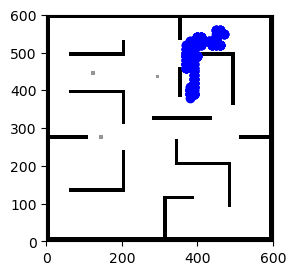

In [13]:
procTime = time.time()

# Importação das informações do mapa
mapaAllPos = mapaAllPos1
G = G1
grid = grid1

# Posição Final Aleatória Válida
posValid = [0,0,0]
posValid[:2] = random.choice(list(mapaAllPos)) # Posição Final Aleatória
posValid[2] = 180*random.random() # Orientação Final Aleatória

# Validação da Posição Final
mapaGoal = np.array([posValid[0], posValid[1], np.deg2rad(posValid[2])])
fGoal = 0
try:
    G[mapaGoal[0], mapaGoal[1]]
    fGoal = 1;
except:
    print ('Posição Final Inválida')

# Goal configuration (x, y, theta)
qgoal = np.array([(mapaGoal[1]/rMC[0])-mapCoppelia/2, -((mapaGoal[0]/rMC[1])-mapCoppelia/2), mapaGoal[2]])
mapaRobox = []
mapaRoboy = []
    
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1 and fGoal):
    print ('Connected to remote API server')
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)

    # Sensores Ultrassônicos
    conjSensores=[]
    angSensores = [np.deg2rad(90), np.deg2rad(50), np.deg2rad(30), np.deg2rad(10),
                   np.deg2rad(-10), np.deg2rad(-30), np.deg2rad(-50), np.deg2rad(-90),
                   np.deg2rad(-90), np.deg2rad(-140), np.deg2rad(-160), np.deg2rad(-170),
                   np.deg2rad(170), np.deg2rad(160), np.deg2rad(140), np.deg2rad(90)]
    for i in range(1,17):
        returnCode, sensorHandle = sim.simxGetObjectHandle(clientID, "Pioneer_p3dx_ultrasonicSensor" +"{}".format(i), sim.simx_opmode_blocking)
        conjSensores.append(sensorHandle)
    
    # Frame que representa o Goal
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [qgoal[0], qgoal[1], 0.5], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)
    
    # Específico do robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    maxSensor = 0.5
    minSensor = 0.2
    
    # Controlador
    katt = .5
    krep = 5
    kr = .5
    ka = 2
    
    startTime = int(time.strftime("%M"))
    fTempo = 0
    rho = np.inf
    while rho > .5 and fTempo == 0:
        returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot)
        returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot)
        
        mapaRobox.append([round((roboPos[0]+mapCoppelia/2)*rMC[1])])
        mapaRoboy.append([abs(round((roboPos[1]-mapCoppelia/2)*rMC[0]))])
        roboConfig = np.array([roboPos[0], roboPos[1], roboOri[2]])
        
        # Relação Robô -> Goal
        dx, dy = qgoal[:2] - roboConfig[:2]
        rho = np.sqrt(dx**2 + dy**2)
        alpha = normalizeAngle(-roboConfig[2] + np.arctan2(dy,dx))
        
        # Alvo na parte de trás
        if abs(alpha) > np.pi/2:
            kv = -kr
            alphaGoal = normalizeAngle(alpha-np.pi)
        else:
            kv = kr
            alphaGoal = alpha
        
        # Campos Potenciais Repulsão
        Frep = np.zeros(2)
        nSensor = 0;
        for sensorHandle in conjSensores[0:16]:
            sensInfo = sim.simxReadProximitySensor(clientID, sensorHandle, sim.simx_opmode_oneshot)
            
            if sensInfo[1] == True:
                rhoSensor = np.sqrt(sensInfo[2][0]**2 + sensInfo[2][2]**2) # Distância é calculada no Plano X, Z
                angSensor = angSensores[nSensor] + roboConfig[2]

                # Ajuste do Range de detecção do Sensor
                if(rhoSensor < minSensor):
                    rhoSensor = minSensor

                if(rhoSensor<maxSensor):
                    # Campos Potenciais - Repulsão
                    Frep = Frep -np.array([rhoSensor*np.cos(angSensor), rhoSensor*np.sin(angSensor)])
            nSensor +=1
        
        # Campos Potenciais Atração
        Fatt = np.array([dx,dy])
        
        # Limitação da Atração (Distância do Goal Grande e existem Obstáculos)
        if abs(Fatt[0]) > 2 and any(abs(Frep)>0):
            Fatt[0] = np.sign(Fatt[0]) *2
        if abs(Fatt[1]) > 2 and any(abs(Frep)>0):
            Fatt[1] = np.sign(Fatt[1]) *2
        
        # Robô muito próximo do Obstáculo
        if(any(abs(Frep)>.5)):
            # Amplificação do giro
            Fatt = -Fatt
            Frep = 1*Frep
            kv = -1*np.sign(kv)*kr
            kw = -2*ka
        else:
            kv = kv
            kw = ka
            
        # Resultante Campos Potenciais
        Fpot = katt*Fatt +krep*Frep
        rhoFpot = np.sqrt(Fpot[0]**2 + Fpot[1]**2)
        
        #print(kv, rhoFpot)
        #print(kw, alphaGoal, "\n")
        v = kv*rhoFpot
        w = kw*alphaGoal
        
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)
        
        wr = ((2.0*v) + (w*L))/(2.0*r)
        wl = ((2.0*v) - (w*L))/(2.0*r)

        sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
        sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)
        
        nowTime = int(time.strftime("%M"))
        if int(nowTime) == (int(startTime) +2)%59:
            print("Não alcançou a Posição Final")
            fTempo = 1
    
    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho Realizado
    grid[mapaRoboy[1], mapaRobox[1]] = 5
    mapaPlotx = np.interp(mapaRobox[1:], [0,img0.shape[0]],[0,map_dims[0]])
    mapaPloty = np.interp(mapaRoboy[1:], [0,img0.shape[0]],[map_dims[0], 0])
    ax.scatter(mapaPlotx, mapaPloty, c='b', marker='o')
    ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))
    
print("Tempo de Processamento = ", time.time()-procTime)

Como já era de se esperar, devido ao grande número de obstáculos, a técnica de Campos Potenciais não foi capaz de levar o robô às posições finais definidas. Durante a simulação, observou-se que os movimentos foram muito restritos devido à existência de muitos obstáculos, inclusive, gerando Forças de Repulsão excludentes.

A imagem a seguir demonstra o resultado da simulação.

![title](Sim2_Map1.png)

### Mapa 2

Connected to remote API server
Não alcançou a Posição Final
Tempo de Processamento =  92.00712156295776


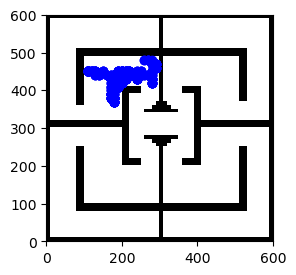

In [15]:
procTime = time.time()

# Importação das informações do mapa
mapaAllPos = mapaAllPos2
G = G2
grid = grid2

# Posição Final Aleatória Válida
posValid = [0,0,0]
posValid[:2] = random.choice(list(mapaAllPos)) # Posição Final Aleatória
posValid[2] = 180*random.random() # Orientação Final Aleatória

# Validação da Posição Final
mapaGoal = np.array([posValid[0], posValid[1], np.deg2rad(posValid[2])])
fGoal = 0
try:
    G[mapaGoal[0], mapaGoal[1]]
    fGoal = 1;
except:
    print ('Posição Final Inválida')

# Goal configuration (x, y, theta)
qgoal = np.array([(mapaGoal[1]/rMC[0])-mapCoppelia/2, -((mapaGoal[0]/rMC[1])-mapCoppelia/2), mapaGoal[2]])
mapaRobox = []
mapaRoboy = []
    
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1 and fGoal):
    print ('Connected to remote API server')
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)

    # Sensores Ultrassônicos
    conjSensores=[]
    angSensores = [np.deg2rad(90), np.deg2rad(50), np.deg2rad(30), np.deg2rad(10),
                   np.deg2rad(-10), np.deg2rad(-30), np.deg2rad(-50), np.deg2rad(-90),
                   np.deg2rad(-90), np.deg2rad(-140), np.deg2rad(-160), np.deg2rad(-170),
                   np.deg2rad(170), np.deg2rad(160), np.deg2rad(140), np.deg2rad(90)]
    for i in range(1,17):
        returnCode, sensorHandle = sim.simxGetObjectHandle(clientID, "Pioneer_p3dx_ultrasonicSensor" +"{}".format(i), sim.simx_opmode_blocking)
        conjSensores.append(sensorHandle)
    
    # Frame que representa o Goal
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [qgoal[0], qgoal[1], 0.5], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)
    
    # Específico do robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    maxSensor = 0.5
    minSensor = 0.2
    
    # Controlador
    katt = .5
    krep = 5
    kr = .5
    ka = 2
    
    startTime = int(time.strftime("%M"))
    fTempo = 0
    rho = np.inf
    while rho > .5 and fTempo == 0:
        returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot)
        returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot)
        
        mapaRobox.append([round((roboPos[0]+mapCoppelia/2)*rMC[1])])
        mapaRoboy.append([abs(round((roboPos[1]-mapCoppelia/2)*rMC[0]))])
        roboConfig = np.array([roboPos[0], roboPos[1], roboOri[2]])
        
        # Relação Robô -> Goal
        dx, dy = qgoal[:2] - roboConfig[:2]
        rho = np.sqrt(dx**2 + dy**2)
        alpha = normalizeAngle(-roboConfig[2] + np.arctan2(dy,dx))
        
        # Alvo na parte de trás
        if abs(alpha) > np.pi/2:
            kv = -kr
            alphaGoal = normalizeAngle(alpha-np.pi)
        else:
            kv = kr
            alphaGoal = alpha
        
        # Campos Potenciais Repulsão
        Frep = np.zeros(2)
        nSensor = 0;
        for sensorHandle in conjSensores[0:16]:
            sensInfo = sim.simxReadProximitySensor(clientID, sensorHandle, sim.simx_opmode_oneshot)
            
            if sensInfo[1] == True:
                rhoSensor = np.sqrt(sensInfo[2][0]**2 + sensInfo[2][2]**2) # Distância é calculada no Plano X, Z
                angSensor = angSensores[nSensor] + roboConfig[2]

                # Ajuste do Range de detecção do Sensor
                if(rhoSensor < minSensor):
                    rhoSensor = minSensor

                if(rhoSensor<maxSensor):
                    # Campos Potenciais - Repulsão
                    Frep = Frep -np.array([rhoSensor*np.cos(angSensor), rhoSensor*np.sin(angSensor)])
            nSensor +=1
        
        # Campos Potenciais Atração
        Fatt = np.array([dx,dy])
        
        # Limitação da Atração (Distância do Goal Grande e existem Obstáculos)
        if abs(Fatt[0]) > 2 and any(abs(Frep)>0):
            Fatt[0] = np.sign(Fatt[0]) *2
        if abs(Fatt[1]) > 2 and any(abs(Frep)>0):
            Fatt[1] = np.sign(Fatt[1]) *2
        
        # Robô muito próximo do Obstáculo
        if(any(abs(Frep)>.5)):
            # Amplificação do giro
            Fatt = -Fatt
            Frep = 1*Frep
            kv = -1*np.sign(kv)*kr
            kw = -2*ka
        else:
            kv = kv
            kw = ka
            
        # Resultante Campos Potenciais
        Fpot = katt*Fatt +krep*Frep
        rhoFpot = np.sqrt(Fpot[0]**2 + Fpot[1]**2)
        
        #print(kv, rhoFpot)
        #print(kw, alphaGoal, "\n")
        v = kv*rhoFpot
        w = kw*alphaGoal
        
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)
        
        wr = ((2.0*v) + (w*L))/(2.0*r)
        wl = ((2.0*v) - (w*L))/(2.0*r)

        sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
        sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)
        
        nowTime = int(time.strftime("%M"))
        if int(nowTime) == (int(startTime) +2)%59:
            print("Não alcançou a Posição Final")
            fTempo = 1
    
    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho Realizado
    grid[mapaRoboy[1], mapaRobox[1]] = 5
    mapaPlotx = np.interp(mapaRobox[1:], [0,img0.shape[0]],[0,map_dims[0]])
    mapaPloty = np.interp(mapaRoboy[1:], [0,img0.shape[0]],[map_dims[0], 0])
    ax.scatter(mapaPlotx, mapaPloty, c='b', marker='o')
    ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))
    
print("Tempo de Processamento = ", time.time()-procTime)

E, por fim, como se esperava, um mapa ainda mais complexo e com um número maior de obstáculos, o movimento do robô é ainda mais restrito e ineficiente. Nas simulações observa-se o movimento dos robô sempre em direção aos mínimos locais, uma vez que a técnica de Campos Potenciais não possibilita o contorno dos obstáculos.

A imagem a seguir demonstra o resultado da simulação.

![title](Sim2_Map2.png)

___
# RRT - Robô Holonômico

A última técnica implementada é a *Rapidly-Exploring Random Tree* (RRT), novamente com o robô holonômico. Assim como nas técnicas anteriores, o conhecimento do mapa é necessário e existe um planejamento prévio do maá antes de iniciar o movimento até um ponto final.

De forma similar às simulações anteriores, são desenvolvidos simulações do robô nos três mapas já apresentados.

### Mapa 0

In [4]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])
# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle+np.pi, 2*np.pi) - np.pi

Connected to remote API server
Tempo de Planejamento =  0.5541813373565674
Program ended


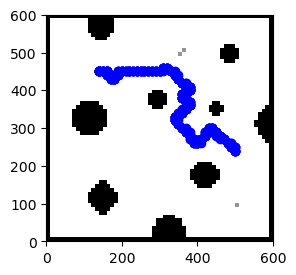

In [9]:
planTime = time.time()

# Importação das informações do mapa
mapaAllPos = mapaAllPos0
G = G0
grid = grid0

# Posição Final Aleatória Válida
posValid = [0,0,0]
posValid[:2] = random.choice(list(mapaAllPos)) # Posição Final Aleatória
posValid[2] = 180*random.random() # Orientação Final Aleatória

# Validação da Posição Final
mapaGoal = np.array([posValid[0], posValid[1], np.deg2rad(posValid[2])])
fGoal = 0
try:
    G[mapaGoal[0], mapaGoal[1]]
    fGoal = 1;
except:
    print ('Posição Final Inválida')

mapaRobox = []
mapaRoboy = []

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1 and fGoal):
    print ('Connected to remote API server')
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Configuração Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
    
    # Dados do Coppelia
    robotname = 'robotino'
    returnCode, roboHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
    
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    # Frame que representa o Goal
    returnCode, checkpointFrame = sim.simxGetObjectHandle(clientID, 'CheckPoints', sim.simx_opmode_oneshot_wait)
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    
    #Definição do Goal
    end_node = (mapaGoal[0], mapaGoal[1])
    mapaGoal[:2] = [-((mapaGoal[0]/rMC[0])-mapCoppelia/2), (mapaGoal[1]/rMC[1])-mapCoppelia/2]
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [mapaGoal[1], mapaGoal[0], .5], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, mapaGoal[2]], sim.simx_opmode_oneshot_wait)
    
    # Implementação do RRT
    mapaRobo = [abs(round((roboPos[1]-mapCoppelia/2)*rMC[0])), round((roboPos[0]+mapCoppelia/2)*rMC[1]), roboOri[2]]
    start_node =  (mapaRobo[0], mapaRobo[1])
    
    rrtPath = nx.DiGraph()
    rrtPath.add_nodes_from([start_node])
    
    rrtStep = 2
    distMin = 3
    startTime = int(time.strftime("%M"))
    fTempo = 0
    fNode = 0
    rho = np.inf
    while rho>distMin and fTempo == 0:
        # A cada 5 medições, 1 é o Goal
        if fNode == 5:
            testPoint = end_node
            fNode = 0
        else:
            testPoint = (random.randint(0,60),random.randint(0,60))
            fNode +=1
        
        # Cálculo de Distância entre Novo Nó e demais Nós
        allNodes = list(rrtPath.nodes())
        dist = []
        for node in allNodes:
            dist.append(np.sqrt((testPoint[0]-node[0])**2 + (testPoint[1]-node[1])**2))
        
        # Nó Repetido
        if abs(np.min(dist)) < 1:
            continue
        
        arg = np.argmin(dist)
        dx = np.round(np.array(testPoint[0]) -np.array(allNodes[arg][0]))
        dy = np.round(np.array(testPoint[1]) -np.array(allNodes[arg][1]))
        
        dx = max(min(dx, rrtStep), -rrtStep)
        dy = max(min(dy, rrtStep), -rrtStep)
        
        newNode = tuple(np.round(np.array(allNodes[arg]) +np.array([dx, dy])))
        
        # Validação da Posição
        try:
            G[newNode]
        except:
            continue;
        
        # Inclusão do Nó na Árvore
        rrtPath.add_edge(allNodes[arg], newNode)
        
        # Distância do último Nó ao Objetivo
        rho = np.sqrt((end_node[0]-newNode[0])**2 + (end_node[1]-newNode[1])**2)
        nowTime = int(time.strftime("%M"))
        if int(nowTime) == (int(startTime) +2)%59:
            print("Não encontrou um caminho até a Posição Final")
            fTempo = 1
    
    # Caminho mais próximo do Goal
    if fTempo:
        testPoint = end_node
            
        # Cálculo de Distância entre Novo Nó e demais Nós
        allNodes = list(rrtPath.nodes())
        dist = []
        for node in allNodes:
            dist.append(np.sqrt((testPoint[0]-end_node[0])**2 + (testPoint[1]-end_node[1])**2))
        
        arg = np.argmin(dist)
        end_node = allNodes[arg]
    
    # Inclusão do Nó Final
    rrtPath.add_edge(newNode, end_node)

    #Desenho da Árvore
    path = nx.shortest_path(rrtPath, source=start_node, target=end_node)
    
    print("Tempo de Planejamento = ", time.time()-planTime)

    # Simulação de movimento baseado no caminho definido
    for posPath in path:
        
        # Transformação Ref.Mapa -> Ref.Coppelia
        qgoal = np.array([posPath[0], posPath[1], mapaGoal[2]])
        qgoal[:2] = [(qgoal[1]/rMC[0])-mapCoppelia/2, -((qgoal[0]/rMC[1])-mapCoppelia/2)]
        
        returnCode = sim.simxSetObjectPosition(clientID, checkpointFrame, -1, [qgoal[0], qgoal[1], .5], sim.simx_opmode_oneshot_wait)
        returnCode = sim.simxSetObjectOrientation(clientID, checkpointFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)
        
        Ctrl = np.array([[2, 0, 0], [0, 2, 0], [0, 0, .5]])
        
        rho = np.inf
        while True:
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)        
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
            
            mapaRobox.append([round((roboPos[0]+mapCoppelia/2)*rMC[1])])
            mapaRoboy.append([abs(round((roboPos[1]-mapCoppelia/2)*rMC[0]))])
        
            # Ajuste Coppelia -> Mapa
            mapaRobo = np.array([roboPos[0], roboPos[1], roboOri[2]])
            
            error = qgoal -mapaRobo
            
            # Margem aceitável de distância durante Movimento
            if ((np.linalg.norm(error[:2]) < mapCoppelia/70)):
                # Posição Final
                if(posPath == path[-1]):
                    # Correção de Giro, apenas
                    Ctrl = np.array([[.1, 0, 0], [0, .1, 0], [0, 0, 1]])
                    if(error[2]<0.1): break
                else: break
                    
            # Controller
            qdot = Ctrl @ error
            
            # Cinemática Inversa w1, w2, w3
            Minv = np.linalg.inv(Rz(roboOri[2]) @ Mdir)
            u = Minv @ qdot
            
            # Enviando velocidades
            sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
    
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho proposto
    grid[start_node] = 5
    grid[mapaRoboy[1], mapaRobox[1]] = 5
    mapaPlotx = np.interp(mapaRobox[1:], [0,img0.shape[0]],[0,map_dims[0]])
    mapaPloty = np.interp(mapaRoboy[1:], [0,img0.shape[0]],[map_dims[0], 0])
    ax.scatter(mapaPlotx, mapaPloty, c='b', marker='o')
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))
    
print('Program ended')

Conforme simulações, a técnica RRT faz com que o robô alcance a posição final através de um mapa gerado com posições aleatórias. 

Na implementação, a cada 5 posições aleatórias escolhidas acontece a escolha da posição final, isso fez com que o Tempo de Planejamento fosse reduzido consideravelmente. Por fim, é possível observar que o caminho desenvolvido não é ótimo, além de acontecerem constantes movimentos oscilatórios.


![title](Sim3_Map0.png)

### Mapa 1

Connected to remote API server
Tempo de Planejamento =  0.6097257137298584
Program ended


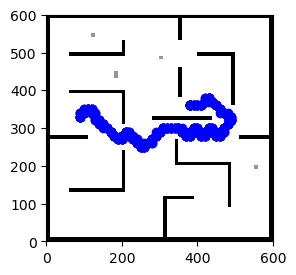

In [16]:
planTime = time.time()

# Importação das informações do mapa
mapaAllPos = mapaAllPos1
G = G1
grid = grid1

# Posição Final Aleatória Válida
posValid = [0,0,0]
posValid[:2] = random.choice(list(mapaAllPos)) # Posição Final Aleatória
posValid[2] = 180*random.random() # Orientação Final Aleatória

# Validação da Posição Final
mapaGoal = np.array([posValid[0], posValid[1], np.deg2rad(posValid[2])])
fGoal = 0
try:
    G[mapaGoal[0], mapaGoal[1]]
    fGoal = 1;
except:
    print ('Posição Final Inválida')

mapaRobox = []
mapaRoboy = []

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1 and fGoal):
    print ('Connected to remote API server')
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Configuração Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
    
    # Dados do Coppelia
    robotname = 'robotino'
    returnCode, roboHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
    
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    # Frame que representa o Goal
    returnCode, checkpointFrame = sim.simxGetObjectHandle(clientID, 'CheckPoints', sim.simx_opmode_oneshot_wait)
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    
    #Definição do Goal
    end_node = (mapaGoal[0], mapaGoal[1])
    mapaGoal[:2] = [-((mapaGoal[0]/rMC[0])-mapCoppelia/2), (mapaGoal[1]/rMC[1])-mapCoppelia/2]
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [mapaGoal[1], mapaGoal[0], .5], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, mapaGoal[2]], sim.simx_opmode_oneshot_wait)
    
    # Implementação do RRT
    mapaRobo = [abs(round((roboPos[1]-mapCoppelia/2)*rMC[0])), round((roboPos[0]+mapCoppelia/2)*rMC[1]), roboOri[2]]
    start_node =  (mapaRobo[0], mapaRobo[1])
    
    rrtPath = nx.DiGraph()
    rrtPath.add_nodes_from([start_node])
    
    rrtStep = 2
    distMin = 3
    startTime = int(time.strftime("%M"))
    fTempo = 0
    fNode = 0
    rho = np.inf
    while rho>distMin and fTempo == 0:
        # A cada 5 medições, 1 é o Goal
        if fNode == 5:
            testPoint = end_node
            fNode = 0
        else:
            testPoint = (random.randint(0,60),random.randint(0,60))
            fNode +=1
        
        # Cálculo de Distância entre Novo Nó e demais Nós
        allNodes = list(rrtPath.nodes())
        dist = []
        for node in allNodes:
            dist.append(np.sqrt((testPoint[0]-node[0])**2 + (testPoint[1]-node[1])**2))
        
        # Nó Repetido
        if abs(np.min(dist)) < 1:
            continue
        
        arg = np.argmin(dist)
        dx = np.round(np.array(testPoint[0]) -np.array(allNodes[arg][0]))
        dy = np.round(np.array(testPoint[1]) -np.array(allNodes[arg][1]))
        
        dx = max(min(dx, rrtStep), -rrtStep)
        dy = max(min(dy, rrtStep), -rrtStep)
        
        newNode = tuple(np.round(np.array(allNodes[arg]) +np.array([dx, dy])))
        
        # Validação da Posição
        try:
            G[newNode]
        except:
            continue;
        
        # Inclusão do Nó na Árvore
        rrtPath.add_edge(allNodes[arg], newNode)
        
        # Distância do último Nó ao Objetivo
        rho = np.sqrt((end_node[0]-newNode[0])**2 + (end_node[1]-newNode[1])**2)
        nowTime = int(time.strftime("%M"))
        if int(nowTime) == (int(startTime) +2)%59:
            print("Não encontrou um caminho até a Posição Final")
            fTempo = 1
    
    # Caminho mais próximo do Goal
    if fTempo:
        testPoint = end_node
            
        # Cálculo de Distância entre Novo Nó e demais Nós
        allNodes = list(rrtPath.nodes())
        dist = []
        for node in allNodes:
            dist.append(np.sqrt((testPoint[0]-end_node[0])**2 + (testPoint[1]-end_node[1])**2))
        
        arg = np.argmin(dist)
        end_node = allNodes[arg]
    
    # Inclusão do Nó Final
    rrtPath.add_edge(newNode, end_node)

    #Desenho da Árvore
    path = nx.shortest_path(rrtPath, source=start_node, target=end_node)
    
    print("Tempo de Planejamento = ", time.time()-planTime)

    # Simulação de movimento baseado no caminho definido
    for posPath in path:
        
        # Transformação Ref.Mapa -> Ref.Coppelia
        qgoal = np.array([posPath[0], posPath[1], mapaGoal[2]])
        qgoal[:2] = [(qgoal[1]/rMC[0])-mapCoppelia/2, -((qgoal[0]/rMC[1])-mapCoppelia/2)]
        
        returnCode = sim.simxSetObjectPosition(clientID, checkpointFrame, -1, [qgoal[0], qgoal[1], .5], sim.simx_opmode_oneshot_wait)
        returnCode = sim.simxSetObjectOrientation(clientID, checkpointFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)
        
        Ctrl = np.array([[2, 0, 0], [0, 2, 0], [0, 0, .5]])
        
        rho = np.inf
        while True:
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)        
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
            
            mapaRobox.append([round((roboPos[0]+mapCoppelia/2)*rMC[1])])
            mapaRoboy.append([abs(round((roboPos[1]-mapCoppelia/2)*rMC[0]))])
        
            # Ajuste Coppelia -> Mapa
            mapaRobo = np.array([roboPos[0], roboPos[1], roboOri[2]])
            
            error = qgoal -mapaRobo
            
            # Margem aceitável de distância durante Movimento
            if ((np.linalg.norm(error[:2]) < mapCoppelia/70)):
                # Posição Final
                if(posPath == path[-1]):
                    # Correção de Giro, apenas
                    Ctrl = np.array([[.1, 0, 0], [0, .1, 0], [0, 0, 1]])
                    if(error[2]<0.1): break
                else: break
                    
            # Controller
            qdot = Ctrl @ error
            
            # Cinemática Inversa w1, w2, w3
            Minv = np.linalg.inv(Rz(roboOri[2]) @ Mdir)
            u = Minv @ qdot
            
            # Enviando velocidades
            sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
    
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho proposto
    grid[start_node] = 5
    grid[mapaRoboy[1], mapaRobox[1]] = 5
    mapaPlotx = np.interp(mapaRobox[1:], [0,img0.shape[0]],[0,map_dims[0]])
    mapaPloty = np.interp(mapaRoboy[1:], [0,img0.shape[0]],[map_dims[0], 0])
    ax.scatter(mapaPlotx, mapaPloty, c='b', marker='o')
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))
    
print('Program ended')

Na simulação, observa-se que o robô, novamente, realizou movimentos oscilatórios e com um tempo de planejamento ainda maior, devido ao número de obstáculos presentes na cena.

A principal consideração da programação desenvolvida, foi evitar que a técnica criasse um caminho que atravessasse qualquer uma das paredes.

![title](Sim3_Map1.png)

### Mapa 2

Connected to remote API server
Tempo de Planejamento =  2.7693238258361816
Program ended


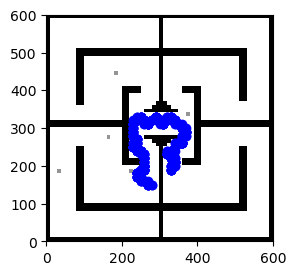

In [22]:
planTime = time.time()

# Importação das informações do mapa
mapaAllPos = mapaAllPos2
G = G2
grid = grid2

# Posição Final Aleatória Válida
posValid = [0,0,0]
posValid[:2] = random.choice(list(mapaAllPos)) # Posição Final Aleatória
posValid[2] = 180*random.random() # Orientação Final Aleatória

# Validação da Posição Final
mapaGoal = np.array([posValid[0], posValid[1], np.deg2rad(posValid[2])])
fGoal = 0
try:
    G[mapaGoal[0], mapaGoal[1]]
    fGoal = 1;
except:
    print ('Posição Final Inválida')

mapaRobox = []
mapaRoboy = []

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1 and fGoal):
    print ('Connected to remote API server')
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Configuração Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
    
    # Dados do Coppelia
    robotname = 'robotino'
    returnCode, roboHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
    
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    # Frame que representa o Goal
    returnCode, checkpointFrame = sim.simxGetObjectHandle(clientID, 'CheckPoints', sim.simx_opmode_oneshot_wait)
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    
    #Definição do Goal
    end_node = (mapaGoal[0], mapaGoal[1])
    mapaGoal[:2] = [-((mapaGoal[0]/rMC[0])-mapCoppelia/2), (mapaGoal[1]/rMC[1])-mapCoppelia/2]
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [mapaGoal[1], mapaGoal[0], .5], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, mapaGoal[2]], sim.simx_opmode_oneshot_wait)
    
    # Implementação do RRT
    mapaRobo = [abs(round((roboPos[1]-mapCoppelia/2)*rMC[0])), round((roboPos[0]+mapCoppelia/2)*rMC[1]), roboOri[2]]
    start_node =  (mapaRobo[0], mapaRobo[1])
    
    rrtPath = nx.DiGraph()
    rrtPath.add_nodes_from([start_node])
    
    rrtStep = 2
    distMin = 3
    startTime = int(time.strftime("%M"))
    fTempo = 0
    fNode = 0
    rho = np.inf
    while rho>distMin and fTempo == 0:
        # A cada 5 medições, 1 é o Goal
        if fNode == 5:
            testPoint = end_node
            fNode = 0
        else:
            testPoint = (random.randint(0,60),random.randint(0,60))
            fNode +=1
        
        # Cálculo de Distância entre Novo Nó e demais Nós
        allNodes = list(rrtPath.nodes())
        dist = []
        for node in allNodes:
            dist.append(np.sqrt((testPoint[0]-node[0])**2 + (testPoint[1]-node[1])**2))
        
        # Nó Repetido
        if abs(np.min(dist)) < 1:
            continue
        
        arg = np.argmin(dist)
        dx = np.round(np.array(testPoint[0]) -np.array(allNodes[arg][0]))
        dy = np.round(np.array(testPoint[1]) -np.array(allNodes[arg][1]))
        
        dx = max(min(dx, rrtStep), -rrtStep)
        dy = max(min(dy, rrtStep), -rrtStep)
        
        newNode = tuple(np.round(np.array(allNodes[arg]) +np.array([dx, dy])))
        
        # Validação da Posição
        try:
            G[newNode]
        except:
            continue;
        
        # Inclusão do Nó na Árvore
        rrtPath.add_edge(allNodes[arg], newNode)
        
        # Distância do último Nó ao Objetivo
        rho = np.sqrt((end_node[0]-newNode[0])**2 + (end_node[1]-newNode[1])**2)
        nowTime = int(time.strftime("%M"))
        if int(nowTime) == (int(startTime) +2)%59:
            print("Não encontrou um caminho até a Posição Final")
            fTempo = 1
    
    # Caminho mais próximo do Goal
    if fTempo:
        testPoint = end_node
            
        # Cálculo de Distância entre Novo Nó e demais Nós
        allNodes = list(rrtPath.nodes())
        dist = []
        for node in allNodes:
            dist.append(np.sqrt((testPoint[0]-end_node[0])**2 + (testPoint[1]-end_node[1])**2))
        
        arg = np.argmin(dist)
        end_node = allNodes[arg]
    
    # Inclusão do Nó Final
    rrtPath.add_edge(newNode, end_node)

    #Desenho da Árvore
    path = nx.shortest_path(rrtPath, source=start_node, target=end_node)
    
    print("Tempo de Planejamento = ", time.time()-planTime)

    # Simulação de movimento baseado no caminho definido
    for posPath in path:
        
        # Transformação Ref.Mapa -> Ref.Coppelia
        qgoal = np.array([posPath[0], posPath[1], mapaGoal[2]])
        qgoal[:2] = [(qgoal[1]/rMC[0])-mapCoppelia/2, -((qgoal[0]/rMC[1])-mapCoppelia/2)]
        
        returnCode = sim.simxSetObjectPosition(clientID, checkpointFrame, -1, [qgoal[0], qgoal[1], .5], sim.simx_opmode_oneshot_wait)
        returnCode = sim.simxSetObjectOrientation(clientID, checkpointFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)
        
        Ctrl = np.array([[2, 0, 0], [0, 2, 0], [0, 0, .5]])
        
        rho = np.inf
        while True:
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)        
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, roboHandle, -1, sim.simx_opmode_oneshot_wait)
            
            mapaRobox.append([round((roboPos[0]+mapCoppelia/2)*rMC[1])])
            mapaRoboy.append([abs(round((roboPos[1]-mapCoppelia/2)*rMC[0]))])
        
            # Ajuste Coppelia -> Mapa
            mapaRobo = np.array([roboPos[0], roboPos[1], roboOri[2]])
            
            error = qgoal -mapaRobo
            
            # Margem aceitável de distância durante Movimento
            if ((np.linalg.norm(error[:2]) < mapCoppelia/70)):
                # Posição Final
                if(posPath == path[-1]):
                    # Correção de Giro, apenas
                    Ctrl = np.array([[.1, 0, 0], [0, .1, 0], [0, 0, 1]])
                    if(error[2]<0.1): break
                else: break
                    
            # Controller
            qdot = Ctrl @ error
            
            # Cinemática Inversa w1, w2, w3
            Minv = np.linalg.inv(Rz(roboOri[2]) @ Mdir)
            u = Minv @ qdot
            
            # Enviando velocidades
            sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
    
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho proposto
    grid[start_node] = 5
    grid[mapaRoboy[1], mapaRobox[1]] = 5
    mapaPlotx = np.interp(mapaRobox[1:], [0,img0.shape[0]],[0,map_dims[0]])
    mapaPloty = np.interp(mapaRoboy[1:], [0,img0.shape[0]],[map_dims[0], 0])
    ax.scatter(mapaPlotx, mapaPloty, c='b', marker='o')
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))
    
print('Program ended')

Por fim, a última simulação foi desenvolvida no mapa que possui ainda mais restrições de movimentos e, como pode-se observar, o tempo de planejamento da trajetória foi o maior, comparado a todas as técnicas e simulações prévias.

Novamente, o movimento não é ótimo e movimentos oscilatórios são apresentados por todos os percursos desenvolvidos, conforme mostrado na imagem.

![title](Sim3_Map2.png)

___
# Conclusões

O Trabalho Prático realizado, teve como objetivo a implementação e simulação de três técnicas diferentes de planejamento e controle das trajetórias, sendo elas:
- Roadmap
- Campos Potenciais
- *Rapidly-Exploring Random Tree*

Das técnicas listadas, somente o Campo Potencial foi utilizado como Controle, sem que houvesse um planejamento prévio do caminho a ser perseguido. Nas demais técnicas implementadas, houve um planejamento dos possíveis caminhos e, se fosse possível identificar tal percurso, o robô recriaria o movimento previsto.
A escolha do Campo Potencial seguindo a hierarquia Reativa, se deve ao formato dos mapas criados e pela técnica não ser completa, ou seja, não existe a garantia de o robô conseguir sempre alcançar a localização final. Desta forma, foram propostos movimentos que pudesse possibilitar uma variação do campo de visão do robô quando este atingisse um mínimo local.

Após todas as simulações demonstradas, foram demonstrados benefícios importantes em alguma das técnicas comparado às outras, mas também, situações problemáticas, conforme descritas a seguir, por técnica.

### Roadmap

O Roadmap depende de uma discretização do mapa que, muitas vezes, é realizado de forma extremamente restrita, principalmente quando os obstáculos estão em maior número e com menor espaço de movimento entre eles.

A relação de discretização é relativamente complicada, considerando que, caso o mapa seja muito amplo, será considerado um número de posições extremamente grande. Além disso, dependendo do tamanho da célula, o robô pode não considerar movimentos entre obstáculos.


### Campo Potencial

O Campo Potencial, comparado à técnica de Roadmap implementada, tem um ganho considerável que é o movimento na diagonal, tendendo a alcançar a posição final com maior velocidade, caso não hajam obstáculos no caminho.

Entretanto, nesta mesma lógica, se for considerado um ponto final distante da posição atual, o robô passa a ter uma Força de Atração elevada que, na simulação, pode levar o robô a colidir com um obstáculo antes mesmo de ser calculado uma Força de Repulsão considerável ao movimento. Como solução para esta questão, limitar a Força de Atração foi necessário.

Por fim, quando observados obstáculos muito próximos entre si, mas com condições do robô atravessar entre eles, o Campo Potencial resultante pode ser em direção ao obstáculo, o que também atrapalha a simulação.


### *Rapidly-Exploring Random Tree*

A técnica RRT foi completamente desenvolvida considerando as posições válidas desenvolvidas pelo grid inicial de cada mapa. A partir desse grid, foram especificadas posições diferentes que poderiam, inclusive, ser a posição final do mapa. Essa implementação contou com a utilização da biblioteca NetworkX do Python, que auxilia na criação dos ramos. Conforme observado nas simulações, por depender de escolhas aleatórias de posição em todo o mapa, a técnica acabou por demandar um planejamento mais longo comparado às demais técnicas.

Os resultados obtidos em todos os mapas indicaram benefícios comparado ao Roadmap quanto à trajetória desenvolvida, uma vez que eram aceitáveis movimentos diretamente orientados à posição final. Entretanto, como a implementação demandava a existência de um ramo próximo ao objetivo para finalizar o planejamento, o percurso final apresentou diversas oscilações desnecessárias ou que poderiam ser corrigidas com a estimação de mais ramos.

Por fim, a solução foi relativamente boa, mas com consideráveis possibilidades de melhorias.

# Referências

- **Jupyter {Book}**. https://jupyterbook.org/intro.html
- **Imageio 2.9.0**. https://pypi.org/project/imageio/
- **Matplotlib 3.3.4**. https://matplotlib.org/3.3.4/index.html
- **Seaborn 0.11.1**. https://seaborn.pydata.org/#
- **NetworkX**. https://networkx.org/
- **Introduction to Autonomous Mobile Robots**. Roland Siegwart, Illah R. Nourbakhsh.
- **Robótica Móvel 1º Semestre de 2021**. Douglas G. Macharet.